# Santander Value Prediction Challenge

## Description

According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

## Evaluation

![Evaluation Metric](./images/evaluation.png)

## Importing Python Packages

In [13]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

from collections import defaultdict

# Additional Configuration
pd.set_option('display.max_columns', 0)
sns.set(style="whitegrid", color_codes=True)
matplotlib.rc('axes', edgecolor='white')
matplotlib.rc('xtick', color='white')
matplotlib.rc('ytick', color='white')
%matplotlib inline

## Explorarory Data Analysis

### 1. Loading the Datasets

In [3]:
train_raw = pd.read_csv('./datasets/train.csv')
test_raw = pd.read_csv('./datasets/test.csv')

print("Training dataset shape: ", train_raw.shape)
print("Testing dataset shape: ", test_raw.shape)

Training dataset shape:  (4459, 4993)
Testing dataset shape:  (49342, 4992)


In [3]:
train_raw.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,0b8e10df6,603e85eb7,...,19915a6d3,20a325694,8afae1db8,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,24000000.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [4]:
test_raw.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,...,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.528249e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.175880e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3360000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,20884000.0,0.0,0.0,0.0,0.0,0.0,36252000.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.

### 2. Displaying Dataset Information

In [4]:
dtype_df = train_raw.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


#### Columns with Zero Values Proportion

In [5]:
zero_values_train = np.abs(-100 + (train_raw.astype(bool).sum(axis=0) * 100)/train_raw.shape[0])
zero_values_test = np.abs(-100 + (test_raw.astype(bool).sum(axis=0) * 100)/test_raw.shape[0])

In [9]:
zero_df = pd.DataFrame({'Train': zero_values_train, 'Test': zero_values_test})
zero_df = zero_df.drop(['ID'])
zero_df.sort_values(['Test'])
important_columns = zero_df[zero_df['Test'] < 93].index.tolist()
zero_df[zero_df['Test'] < 93].index

Index(['024c577b9', '02861e414', '041c5d0c9', '0572565c2', '0c9462c08',
       '0d51722ca', '0ff32eb98', '11e12dbe8', '122c135ed', '15ace8c9f',
       '1702b5bf0', '190db8488', '1931ccfdd', '1c71183bb', '1db387535',
       '1fe5d56b9', '20aa07010', '23310aa6f', '241f0f867', '26fc93eb7',
       '29c059dd2', '2e103d632', '2ec5b290f', '32174174c', '324921c7b',
       '3bdee45be', '3d6d38290', '44d5b820f', '491b9ee45', '4bcf15776',
       '51d4053c7', '57dd44c29', '58232a6fb', '58e056e12', '58e2e02e6',
       '5a1589f1a', '5c6487af1', '62e59a501', '62fb56487', '63c094ba4',
       '6619d81fc', '66ace2992', '68a945b18', '6c0e0801a', '6c5c8869c',
       '6eef030c1', '703885424', '70feb1494', '850027e38', '8781e4b91',
       '87ffda550', '8e4d0fe45', '91f701ba2', '961b91fe7', '963a49cdc',
       '9fd594eec', 'a6b6bc34a', 'a93118262', 'aac52d8d9', 'ad009c8b9',
       'adb64ff71', 'b43a7cfd5', 'b4cfe861f', 'b6daeae32', 'b7c931383',
       'bd6da0cca', 'c10f31664', 'c47340d97', 'c5a231d81', 'c8d5

#### Columns with Constant Value

In [7]:
unique_df = train_raw.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

#### Removing Columns with Constant Values (Single Unique Value)

In [8]:
train_df = train_raw.drop(constant_df.col_name.tolist(), axis=1)
test_df = test_raw.drop(constant_df.col_name.tolist(), axis=1)
train_df.shape

(4459, 4737)

### 3. Target Distribution

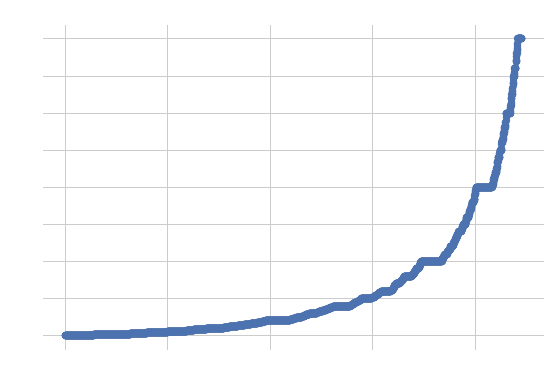

In [10]:
plt.figure(figsize=(9,6))
plt.scatter(range(train_raw.shape[0]), np.sort(train_raw['target'].values))
plt.xlabel('index', fontsize=12, color='#FFFFFF')
plt.ylabel('Target', fontsize=12, color='#FFFFFF')
plt.title("Target Distribution", fontsize=14, color='#FFFFFF')
plt.show()

#### Target Histogram

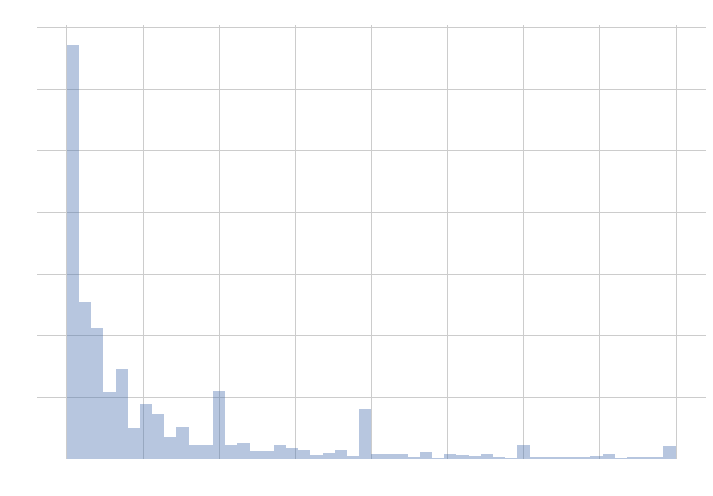

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(train_raw["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

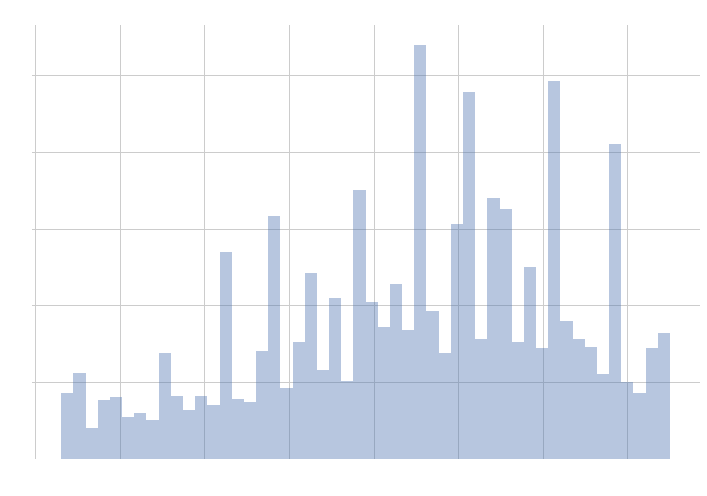

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_raw["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

### 4. Correlation Analysis

In [210]:
labels = [x for x in train_df.columns if x not in ['ID', 'target']]
values = [np.corrcoef(train_df[x].values, train_df['target'].values)[0,1] for x in train_df.columns if x not in ['ID', 'target']]

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

# Generating Bar Plot For Correlation > 0.2
corr_df = corr_df[(corr_df['corr_values']>0.2) | (corr_df['corr_values']<-0.2)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,50))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient", color='white')
ax.set_title("Correlation coefficient of the variables", color='white')

plt.show()

#### Correlation Heat Map

In [209]:
cols_to_use = corr_df[(corr_df['corr_values']>0.25) | (corr_df['corr_values']<-0.25)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(14, 14))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

### 5. Models 

In [300]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

def fit_model(model, X, Y, cross_val=False, cv_folds=5):
    model.fit(X, Y)
    if cross_val:
        evaluate_cross_validation(model, X, Y, cv_folds)
        
def evaluate_cross_validation(model, X, Y, K):
    cv = KFold(n_splits=K, shuffle=True, random_state=2)
    scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=cv)
    Y_pred = model.predict(X)
    print(scores)
    print("Mean score: {0:.4f} (+/-{1:.4f})".format(scores.mean(), scores.std()))
    print("\nModel Report:")
    print("Training")
    print("Root Mean Squared Error : %.4g" % np.sqrt(mean_squared_error(Y, Y_pred)))

In [10]:
train_pre = train_df.drop(['ID', 'target'], axis=1)
train_Y = np.log1p(train_df['target'].values)
test_pre = test_df.drop(['ID'], axis=1)

#### Selecting Important Features

In [11]:
train_imp_feat_train = train_pre[important_columns]
train_imp_feat_test = test_pre[important_columns]

train_pre = train_pre.drop(important_columns, axis=1)
test_pre = test_pre.drop(important_columns, axis=1)

#### Standarize the Data

In [12]:
%%time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(train_pre)

# Apply transform to both the training set and the test set.
train_scaled = scaler.transform(train_pre)
test_scaled = scaler.transform(test_pre)

scaled_df_train = pd.DataFrame(train_scaled, columns=train_pre.columns)
scaled_df_test = pd.DataFrame(test_scaled, columns=test_pre.columns)

CPU times: user 2.65 s, sys: 2.2 s, total: 4.85 s
Wall time: 5.36 s


#### Truncated SVD

In [14]:
%%time
svd = TruncatedSVD(n_components=3500)
svd.fit(scaled_df_train)

CPU times: user 2min 53s, sys: 4.96 s, total: 2min 58s
Wall time: 51.6 s


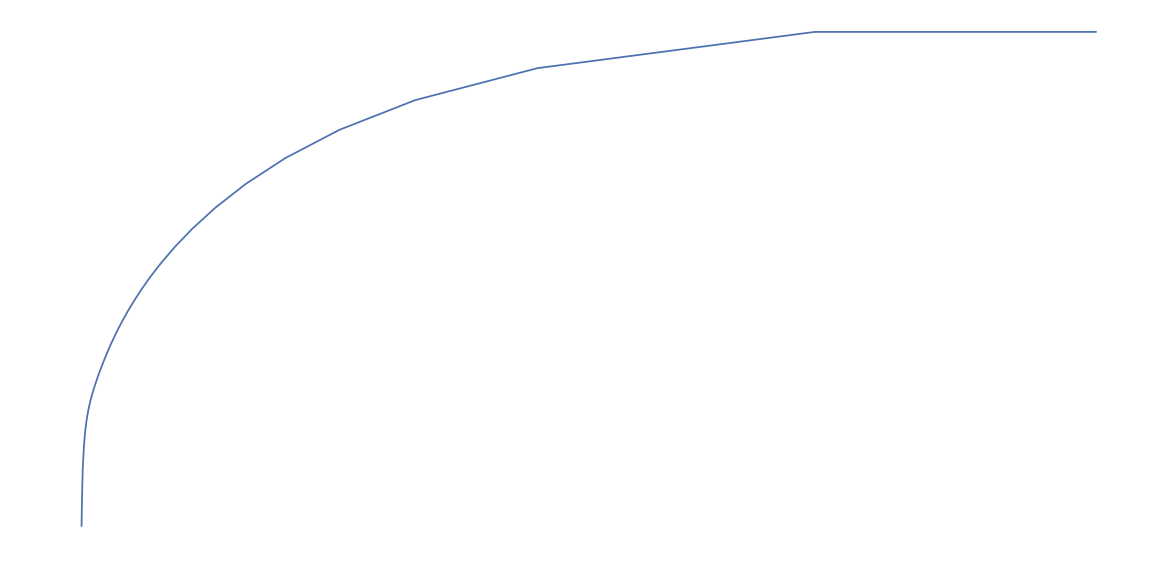

In [283]:
# Printing the explained variance
plt.figure(figsize=(20,10))
plt.plot(variance_sum)
plt.grid()

In [15]:
%%time
# Make an instance of the Model
svd_selected = TruncatedSVD(n_components=1700, n_iter=10,random_state=42)

svd_selected.fit(scaled_df_train)

CPU times: user 1min 30s, sys: 2.8 s, total: 1min 33s
Wall time: 25.5 s


From the previous graph we can see that around 1750 components are necessary to explain most of the variance of the data, so this is a good number of components to try.

In [287]:
scaled_df_train = svd_selected.transform(scaled_df_train)
scaled_df_test = svd_selected.transform(scaled_df_test)

In [288]:
svd_features_train = pd.DataFrame(data = scaled_df_train)
svd_features_test = pd.DataFrame(data = scaled_df_test)

#### Final Dataset

In [289]:
train_X = pd.concat([train_imp_feat_train, svd_features_train], axis = 1)
test_X = pd.concat([train_imp_feat_test, svd_features_test], axis = 1)

#### Extra Trees Model

In [302]:
%%time
from sklearn import ensemble
extra_model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=10, max_features=0.5, n_jobs=-1, random_state=0)
fit_model(extra_model, train_X, train_Y, cross_val=True)

[-2.58068249 -2.46769632 -2.64117757 -2.45243746 -2.55482573]
Mean score: -2.5394 (+/-0.0707)

Model Report:
Training
Root Mean Squared Error : 1.302
CPU times: user 5min 22s, sys: 731 ms, total: 5min 23s
Wall time: 44.2 s


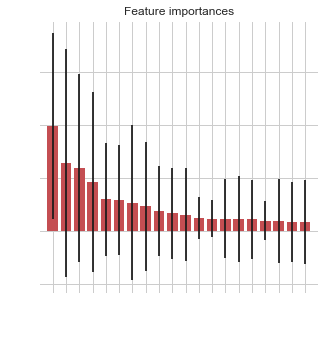

In [296]:
## plot the importances ##
feat_names = train_X.columns.values
importances = extra_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(5,5))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [297]:
# Predicting the target
pred_test_y = extra_model.predict(test_X)
pred_test_exp = np.expm1(pred_test_y)

# Creating Submission File
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_exp
sub_df.to_csv("./predictions/baseline_extra_svd_1.csv", index=False)

#### XGBOOST

In [305]:
%%time
import xgboost as xgb
import model_utils
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor()
fit_model(xgb_model, train_X, train_Y, cross_val=True)

[-2.2251808  -2.22256757 -2.28149559 -2.22471382 -2.27478707]
Mean score: -2.2457 (+/-0.0265)

Model Report:
Training
Root Mean Squared Error : 1.23
CPU times: user 3min 54s, sys: 2.62 s, total: 3min 57s
Wall time: 35.8 s


In [307]:
# Predicting the target
pred_test_y = xgb_model.predict(test_X)
pred_test_exp = np.expm1(pred_test_y)

# Creating Submission File
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_exp
sub_df.to_csv("./predictions/xgboost_1_28Jun.csv", index=False)

In [308]:
%%time
from sklearn.model_selection import GridSearchCV 

xgb_model = xgb.XGBRegressor()
params = {'max_depth': [3, 5, 7], 'n_estimators': [100, 150]}
reg = GridSearchCV(xgb_model, param_grid=params, n_jobs = 1, cv = 3, scoring='neg_mean_squared_error')
reg.fit(train_X, train_Y)

# summarize results
print("Best: %f using %s" % (reg.best_score_, reg.best_params_))
means = reg.cv_results_['mean_test_score']
stds = reg.cv_results_['std_test_score']
params = reg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2.301985 using {'max_depth': 3, 'n_estimators': 100}
-2.301985 (0.088902) with: {'max_depth': 3, 'n_estimators': 100}
-2.306403 (0.088254) with: {'max_depth': 3, 'n_estimators': 150}
-2.331390 (0.102002) with: {'max_depth': 5, 'n_estimators': 100}
-2.342226 (0.104309) with: {'max_depth': 5, 'n_estimators': 150}
-2.388265 (0.097130) with: {'max_depth': 7, 'n_estimators': 100}
-2.389189 (0.097261) with: {'max_depth': 7, 'n_estimators': 150}
CPU times: user 22min 12s, sys: 22 s, total: 22min 34s
Wall time: 3min 28s


In [309]:
%%time
xgb_model_tuned = xgb.XGBRegressor(max_depth=3, n_estimators=100)
fit_model(xgb_model_tuned, train_X, train_Y, cross_val=True)

[-2.2251808  -2.22256757 -2.28149559 -2.22471382 -2.27478707]
Mean score: -2.2457 (+/-0.0265)

Model Report:
Training
Root Mean Squared Error : 1.23
CPU times: user 4min, sys: 2.77 s, total: 4min 3s
Wall time: 35 s


#### LightGBM Model

In [310]:
import lightgbm as lgb

In [327]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 64,
        "learning_rate" : 0.01,
        "max_depth": 8,
        "bagging_fraction" : 0.5,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "reg_alpha": 0.3,
        "reg_lambda": 0.1,
        "min_split_gain": 2,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [316]:
kf = KFold(n_splits=5, shuffle=True, random_state=128)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_Y[dev_index], train_Y[val_index]
    pred_test, model_pca, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.51092
[400]	valid_0's rmse: 1.48621
[600]	valid_0's rmse: 1.48292
[800]	valid_0's rmse: 1.4834
Early stopping, best iteration is:
[702]	valid_0's rmse: 1.48226
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.5416
[400]	valid_0's rmse: 1.50713
[600]	valid_0's rmse: 1.50457
Early stopping, best iteration is:
[533]	valid_0's rmse: 1.5034
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.47014
[400]	valid_0's rmse: 1.43889
[600]	valid_0's rmse: 1.43564
Early stopping, best iteration is:
[684]	valid_0's rmse: 1.43422
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.51277
[400]	valid_0's rmse: 1.48205
[600]	valid_0's rmse: 1.48166
Early stopping, best iteration is:
[530]	valid_0's rmse: 1.48048
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.47935
[400]	va

In [317]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("./predictions/baseline_lgb_svd_2.csv", index=False)